In [410]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from microtc.textmodel import TextModel
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import  MultinomialNB
from sklearn.metrics import f1_score as f1, accuracy_score as acc 
from sklearn.preprocessing import MinMaxScaler

# Análisis semántico

Los vectores TF-IDF (términos frecuencia-vectores de frecuencia inversa del documento) que definimos en las secciones previas pueden ser utilizado para  determinar la importancia de las palabras en un fragmento de texto. Así como para calcular la importancia de cada palabra para el significado general de un fragmento de texto en una colección de documentos. 
Los valores de `importancia` de TF-IDF, también pueden ser calculados para secuencias cortas de palabras, es decir para $n$-gramas. Sin embargo los sistemas de NLP quiere ir más allá, se desea que una máquina sea capaz de comprender el `significado` de las palabras.

Una de las formas de hacerlo mediante el uso de `WordEmbeddings` que revisamos brevemente en la sección previa. Por otro lado una de la primeras formas que se utilizaron es el denominado análisis semántico latente (latent semantic analysis LSA). El uso de LSA, no solo permite representar el significado de las palabras como vectores, sino que permite que las usarlas para representar el significado de documentos completos, es decir el tópico del que trata el documento.

En esta sección, se presentarán los que denominaremos vectores semánticos o de tópico/tema. Se obtienen mediante el uso TF-IDF para calcular `índices` (socres) de tema que componen las dimensiones de los vectores de tópico. Lo anterior se basa en  el uso de la correlación de frecuencias de términos normalizados entre sí para agrupar palabras que consitutirán un tema.
Los vectores de tópicos de pueden utilizar para identificar documentos en función de su significado: búsqueda semántica. La mayoría de las veces, la búsqueda semántica es mejor que la búsqueda por palabras clave.  La búsqueda semántica es capaz de obtener resultados incluso cuando no se incluyen los términos exactos en la consulta.

Mediante el uso de los vectores semánticos para identificar las palabras y n-gramas que mejor representan el tópico de una sentencia, documento o colección de documentos (corpus). Con los vectores semánticos es posible comparar que tan `similares` en siginificado son dos elementos (sentencias, documentos).

## Frecuencia de términos  y pesado  de tópicos

Los vectores TF-IDF se generar mediante el conteo de las palabras en un documento, cada términos debe coincidir de fomar exacta para se contenado en la misma palabra (al menos así es cuando no se utiliza steming o lematización). Po lo tanto, los términos que tienen el mismo significado pero se escriben diferente  tendrán representaciones de vectoriales TF-IDF completamente diferentes. Es por ello que las búsquedas por palabra clave  pueden exihibir un desempeño pobre en representaciones basada en frecuencia de términos.

Meidante el uso de stemming/lematización, la palabras que comparten una misma raíz se agrupan en un sola término, con lo cual de obtienen colecciones de palabras con grafías similares y, a menudo, significados similares. La etiqueta de cada colección de palabras reemplaza en la lista de tokens a las palabras originales.

El enfoque previo solo garantiza que palabras escritas `de manera similar` se unifican en un solo token, pero no necesariamente garantiza que sus significados sean similares. Ni tampoco puede ser utilizada para emparejar la mayoría de los sinónimos. Esto ya que los sinónimos suelen diferir en más formas que las terminaciones de las palabras con las que se ocupan la lematización y stemming. Peor aún, la lematización/steaming a veces agrupan erróneamente antónimos, palabras con significado opuesto.

Derivado de lo anterior puede ocurrir que dos fragmentos de texto que hablan sobre lo mismo pero usan palabras diferentes no serán identificados como  `similares/cercanos` entre sí en un espacio vectorial TF-IDF lematizado. Además, es común,  que dos vectores TF-IDF que utilizan derivaciones que son `cercanos` entre si, no necesariamente tienen un significado similar. 


### Vectores de  tópicos(tema)

La estadística de palabras obtenidas por la representación TF-IDF, nos permite realizar operaciones matemáticas. Sin embargo, esas opercaiones nodicen mucho sobre como están relacionados los significados de las sentencias. También es posible calcular las representaciones TF-IDF palabra a palabra (vectores de co-ocurrencia o correlación de palabras) multiplicando la matriz TF-IDF por sí misma. Pero el `razonamiento vectorial` con estos vectores escasos y de alta dimensión no funciona bien. Las operaciones con estos vectores entre sí, no representan bien un concepto, palabra o tópico existente. 

En particular, nos  gustaría representar ese significado con un vector que al diferencia de un vector TF-IDF sea mas compacto (menor dimensión) y con más significado. A estos vectores de significado se les conoce `vectores palabra-tema`. Cuando estos vectores se crean por documente se les denomina `vectores de documento-tema`. Podemos referirnos a ellos indistitamento como `vectores de tema` o `vectores de tópico`. Estos vectores temáticos pueden ser compactos o de alta dimensión como desee.

Lo vectores de tópico a defierencia de TF-IDF perminten que la operaciones como sumas y diferencias representen una relación entre el significado de los elementos implicados. Es decir, podemos utilizar las distancias entre los vectores de tema para realizar  agrupación de documentos o búsqueda semántica. Mientras que TF-TIDF, permite  agrupar y buscar usando palabras clave.

Partiendo de que se obtiene un vector palabra-tema para cada palabra en su léxico (vocabulario). Es posible calcular el vector de tema para cualquier documento nuevo simplemente sumando todos sus vectores de tema de palabra.

Sin embargo, obtener una representación numérica de la semántica (significado) de palabras y oraciones puede ser complicado. Esto es especialmente cierto para los idiomas `difusos` como el inglés o el español, que tiene varios dialectos y múltiples interpretaciones diferentes de las mismas palabras. Este concepto de palabras con múltiples significados se llama polisemia:

- **Polisemia**: es la existencia de palabras y frases con más de un significado.

A continuación enumeramos algunas formas en las que la polisemia puede afectar la semántica de una palabra o enunciado:

- Escritos:
    - *Homónimos*: palabras con la misma ortografía y pronunciación, pero con diferentes significados.
    - *Zeugma* : uso de dos significados de una palabra simultáneamente en la misma oración 

- Voz
    - *Homógrafos* : las palabras se escriben igual, pero con diferentes pronunciaciones y significados
    - *Homófonos*:  palabras con la misma pronunciación, pero diferentes deletreos y significados 

LSA puede lidiar con todos fenómenos polisemicos menccionados. Como ejemplo consider  las siguientes frases:
- `... él tuvo que cortar el tubo ...`
- `Evita evita la confrontación`
- `Grabe este grave asunto`

El problema al que no enfretamos es el reducir un vector TF-IDF de alta dimensión (decenas de miles de términos) a un vector unas pocas dimensiones (unas decenas). Para resolverto debemos encontrar esas dimensiones (palabras) que en conjunto representan un `tópico/tema` y sumar sus valores TF-IDF para crear un nuevo vector que representa la `relevancia` de ese tema en un documento dado. Una vez indentificados, podríamos ponderarlos por lo importantes que son para el tema, incluso podrían tener pesos negativos para las palabras que reducen la probabilidad de que el texto trate sobre ese tema. 

### Un ejemplo 
Supongamos que dado un vector TF-IDF para un documento se desea convertirlo en un vector de tema. Se debe pensar en cuánto contribuye cada palabra a tus temas. Supongamos que se tienen algunas sentencias sobre tres temas `animales`, `educacion` y `salud`. El tema `animales` daría mayor peso a palbaras **leon**, **gato**,etc;  
y probablemente ignoraría palabras como **historia**, **geografia**. El tema `educación` pordría darle poco peso los nombres de animales si tuvieran alguna relación con **ciencias naturales** por ejemplo. Vamos a `generar` un modelo utilizando solo nuestra intución.

In [250]:
topicos={}
# nuestra lista de terminos consiste de solo 6 palabras y generamos sus representaciones tfidf de forma aleatoria
tokens=['perro','gato','historia','examen','vacuna','gripe']
np.random.seed(33) # Para garantizar reproducibilidad
tfidf={token: np.random.rand(6) for  token in tokens } 

In [251]:
tfidf

{'perro': array([0.24851013, 0.44997542, 0.4109408 , 0.26029969, 0.87039569,
        0.18503993]),
 'gato': array([0.01966143, 0.95325203, 0.6804508 , 0.48658813, 0.96502682,
        0.39339874]),
 'historia': array([0.07955757, 0.35140742, 0.16363516, 0.98316682, 0.88062818,
        0.49406347]),
 'examen': array([0.40095924, 0.45129146, 0.72087685, 0.24776828, 0.62277995,
        0.14244882]),
 'vacuna': array([0.20117628, 0.08121773, 0.95347229, 0.05573827, 0.59953648,
        0.72299763]),
 'gripe': array([0.97028972, 0.82156946, 0.52755107, 0.33147673, 0.3539822 ,
        0.0790303 ])}

In [253]:
# ahora suponemos los pesos de cada palabra en cada tópico
pesos_animales=[0.8,0.8,-0.1,-0.1,0.2,0.2] 
# suponemos un peso de 0.5 para perro y gato, 
# -0.1 para historia y examen y  0.2 para vacuna y gripe
pesos_educacion=[0.1,0.1,0.7,0.7,-0.1,-0.1] 
pesos_salud=[0,0,-0.2,-0.2,0.6,0.8] 
topicos['animales']=np.sum([peso*tfidf[token] for peso,token in zip(pesos_animales,tokens)], axis=1)
topicos['educacion']=np.sum([peso*tfidf[token] for peso,token in zip(pesos_educacion,tokens)], axis=1)
topicos['salud']=np.sum([peso*tfidf[token] for peso,token in zip(pesos_salud,tokens)], axis=1)

In [254]:
topicos

{'animales': array([ 1.94012933,  2.79870236, -0.29524586, -0.25861246,  0.52282774,
         0.61677989]),
 'educacion': array([ 0.24251617,  0.34983779,  2.06672104,  1.81028722, -0.26141387,
        -0.30838995]),
 'salud': array([ 0.        ,  0.        , -0.59049173, -0.51722492,  1.56848321,
         2.46711958])}

En este ejercicio los pesos de cada palabra los ponemos en función de la probabilidad que suponemos que cada palabra esté asociada con un tema en particular y sumamos los vectores resultantes. Cuando suponemos que una palabra no está relacionada con el tópico podemos suponer un peso de 0 o incluso un peso negativo si está aumenta la probabilidad que el documento no este relacionado con el tópico. El ejerciocio solo pretenden ilustrar como debería operar el algoritmo que aprenderá los vectores semánticos. 

La transformación al modelado de temas está dada por la matriz de proporciones (pesos) que conecta los temas con cada palabara en el vocabulario (en este cado 3x6). Cada vector TF-IDF de dimension del tamaño del vocabulario (para el ejemplo 6 x 1) debería multiplicarse por la matriz de tópicos  para obtener el vector de tema de 3 x 1.

En este ejemplo intuimos los los pesos, pero para poder implementar un algoritmo deberíamos preguntarnos ¿Cómo podrías optimizarlos pesos? ¿Qué podría utilizarse como medida objetiva de lo pesos? ¿Que efecto tiene el corpus utilizado? Otra persona podría decidir que los pesos asignado sean diferente en ese caso: ¿Qué podríamos hacer para llegar a un consenso sobre sus opiniones sobre estas seis palabras y tres temas?

Note que  la matriz obtenida nos dice como cada tópico es representado por el vocabulario

In [255]:
pd.DataFrame(topicos,index=tokens).transpose()

,perro,gato,historia,examen,vacuna,gripe
animales,1.940129,2.798702,-0.295246,-0.258612,0.522828,0.61678
educacion,0.242516,0.349838,2.066721,1.810287,-0.261414,-0.30839
salud,0.000000,0.000000,-0.590492,-0.517225,1.568483,2.46712


si transponemos la matriz podemos obtener los vectores para cada palabra en terminos de cada tópico

In [256]:
word_vector=pd.DataFrame(topicos,index=tokens)
word_vector

,animales,educacion,salud
perro,1.940129,0.242516,0.000000
gato,2.798702,0.349838,0.000000
historia,-0.295246,2.066721,-0.590492
examen,-0.258612,1.810287,-0.517225
vacuna,0.522828,-0.261414,1.568483
gripe,0.616780,-0.308390,2.467120


[array([ 0.        ,  0.        ,  0.        ,  2.26824338,  0.28353042,
        -0.28353042]),
 array([ 0.        ,  0.        ,  0.        ,  2.65788688,  0.33223586,
        -0.33223586]),
 array([ 0.        ,  0.        ,  0.        , -0.28852972,  2.01970805,
         0.28852972]),
 array([ 0.        ,  0.        ,  0.        , -0.25881364,  1.81169551,
         0.25881364]),
 array([ 0.        ,  0.        ,  0.        , -0.62761197, -0.31380599,
         2.19664191]),
 array([ 0.        ,  0.        ,  0.        , -0.5328907 , -0.26644535,
         1.86511744])]

Text(0.5, 0, 'salud')

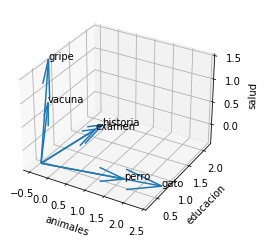

In [263]:
fig = plt.figure()
soa=[np.concatenate(([0,0,0],val)) for val in word_vector.values ]
ax = fig.gca(projection='3d')
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-0.6, 2.5])
ax.set_ylim([0.2, 2.2])
ax.set_zlim([-0.4, 1.5])
for pos,token in zip(word_vector.values,tokens):
    #print(pos[0],pos[1],pos[2],token)
    ax.text(pos[0],pos[1],pos[2],token)
ax.set_xlabel('animales')
ax.set_ylabel('educacion')
ax.set_zlabel('salud')

como nuestro ejemplo las palabra de los diferntes tópicos están bien separados. Estos seis vectores de temas, uno para cada palabra, representan los significados de sus seis palabras como vectores en tres dimensiones.

Si solo calculamos la frecuencia de las apariciones de estas seis palabras y las multiplica por sus pesos, obtendrá el vector de tema tri-dimensional para cualquier documento. Los vectores 3D nos permiten generar una visualización que puede resultar de ayuda para realizar un análisis exploratorio, además también pueden utilizarse para los problemas de clasificación de aprendizaje automático. Recuerde que:  un algoritmo de clasificación lineal divide el espacio vectorial con un plano (o hiperplano) para dividir el espacio en clases. Los documentos del corpus pueden usar muchas más palabras, pero un modelo de vector de tema en particular solo se verá influenciado por el uso del conjunto de palabras que definen el tema.

Un modelo basado en tópicos solo separa los documentos basado en el número de temas, por lo que que no se ve "afectado" por el incrementeo del vocabularioa. En ejmplo se comprimió una representación de 6 dimensiónes a una de 3 (una por cada tema).

El proceso que realizamos está principalmente basado en análisis semántico utilizando nuestra intuición y el sentido común para dividir los documentos en temas. Ahora tratemos de poner esa intuición en un algoritmo que nos permita determinar le número de temeas de forma automática. Si lo analizamos, cada una de las sumas ponderadas que utilizamos son solo un producto escalar (producto punto). Y tres productos punto  es solo una multiplicación de matrices o producto interno. Multiplica una matriz de pesos de $3 \times N$ con un vector TF-IDF, donde $N$ es el tamaño del vocabulario. Se obtine un nuevo vector de tema de 3 x 1 para el documento. Lo que hicimos fue transformar un vector de un espacio vectorial (TF-IDF) a otro espacio vectorial de menor dimensión (vectores de tópicos). Un para generación de tópicos debe crear una matriz de $N$ términos por $M$ tópicos, la cual utilizaremos para a partir de un vector de frecuencias de palabras de un documento obtener su vecror de tópico correspondiente en dimensión $M$.

### Pesado de tópicos

Deseamos que un algoritmo sea capaz de identificar qué palabras van juntas o qué significan. El lingüista británico J. R. Firth, estudió las formas en que se puede estimar lo que significa una palabra o morfema. 
En 1957 le dio una pista sobre cómo calcular los temas para las palabras "Puedes conocer una palabra por las que la acompañan" ¿Recuerdad el contexto de los word-embeddings?

Entonces, como determinamos la compañoa de una palabra. El enfoque más simple es calcular la matriz de co-ocurrencias como ya lo hicimos con la bolsa de palabras (BOW) y los vectores TF-IDF.  Podemos hacerlo mejor mediate el uso de LSA para analizar la matriz TF-IDF para agrupar palabras en temas. También funciona en vectores de bolsa de palabras, pero los vectores TF-IDF dan usalmente mejores resultados.

Además LSA también permite optimizar los tópicos y mantener la diversidad en las dimensiones; por lo que cuando se utiliza el modelo de tópicos en lugar del vocabulario originale, se mantiene gran parte del significado (semántica) de los documentos. El número de temas que se requieren para que un modele semántico capture el significado es mucho menor que la cantidad de palabras en el vocabulario de sus vectores TF-IDF. Por lo tanto, a menudo se hace referencia a LSA como una técnica de reducción de dimensiones (si conoce PCA, LSA es un PCA sobre representaciones de documentos). 

Dos algoritmos similares a LSA, con aplicaciones de PLN son: Linear discriminant analysis (LDA) y Latent Dirichlet allocation (LDiA). Mientras que LDA descompone un documento en un único tema. LDiA se parece más a LSA porque puede dividir documentos en tantos temas como desee. 


#### Clasificación utilizando LDA

LDA es uno de los modelos de clasificación y reducción de dimensiones más simples y rápidos que existen. A pesar de su simplicidad LDA muestra un desempeño sobresalinete en muchas aplicaciones, en ocasiones incluso competitiva con  algoritmos del estado del arte. Como LDA es un algoritmo supervisado, requiere las etiquetas/clases de documento. Ahora mostraremos una implemntación simple que consiste de solo 3 pasos (tomadas de [1]).

1. Calcule la posición promedio (centroide) de todos los vectores TF-IDF dentro de la clase.
2. Calcule la posición promedio (centroide) de todos los vectores TF-IDF que no están en la clase.
3. Calcule la diferencia vectorial entre los centroides (el vector que los une).

Todo lo que se requiere para  “entrenar” un modelo LDA es encontrar el vector (línea) entre los dos centroides para una problema de clasificación binaria. Por ejemplo utilicemos los tweets de EmoVal para disitinguir si un texto particular es o no ofensivo. 

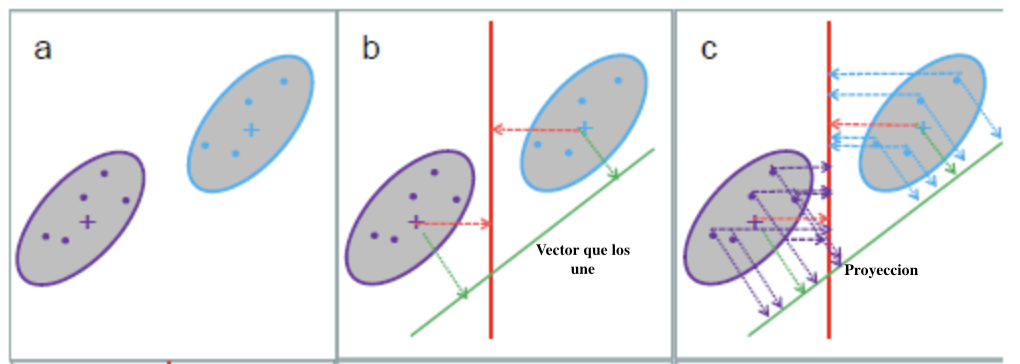

In [266]:
train_df=pd.read_csv('data/train_emo.tsv',sep='\t')
test_df=pd.read_csv('data/dev_emo.tsv',sep='\t') 

In [293]:
test_df.describe()

,id,event,tweet,offensive,emotion
count,844,844,844,844,844
unique,844,8,844,2,7
top,a705702b-a6d0-4c19-a5b7-137f4f97405e,WorldBookDay,Hay grandes muestras de la grandeza humana y #...,NO,others
freq,1,139,1,768,414


In [275]:
# Generamos un modelo microtc y tranformamos los textos
mtc=TextModel()
mtc.fit(train_df.tweet)
train=mtc.transform(train_df.tweet)
test=mtc.transform(test_df.tweet)

In [291]:
# Usamos un labelencorder
le=LabelEncoder()
le.fit(train_df.offensive)
y=le.transform(train_df.offensive)
yt=le.transform(test_df.offensive)

In [376]:
#Utilizamos un modelo naibe bayes
nb=MultinomialNB()
nb.fit(train,y)
print(f"test f1 score:{f1(yt,nb.predict(test))}, accuracy:{acc(yt,nb.predict(test))}")
print(f"train f1 score:{f1(y,nb.predict(train))}, accuracy:{acc(y,nb.predict(train))}")

test f1 score:0.0, accuracy:0.909952606635071
train f1 score:0.0, accuracy:0.9178752402586057


In [298]:
# El tamaño del vocabulario
train.shape

(5723, 18489)

Tenemos  18489 palabras en su vocabulario.  En este caso en particular tenemos más del triple de palabras que tweets. Y si lo hacemos por clase la diferencia es peor. Por lo general, como pudo observar un clasificador Naive Bayes no funcionará bien cuando su vocabulario es mucho mayor que el número de ejemplos etiquetados en su conjunto de entrenamiento. En estás circunstancias, podemos echar mano de la técnicas de análisis semántico. Aún cuando `sklearn` ya cuenta con una implementación como en este caso, solo es necesario los centroides de cada una de las dos clases binaria (NO, OFF) implementaremos nuestra propia versión. 

In [379]:
class miLDA:
    def __init__(self,X,y):
        centroid_no = X[y==0].mean(axis=0) # calulamos el centroide para clase no ofensivo
        centroid_off = X[y==1].mean(axis=0) # calulamos el centroide para clase ofensivo
        self.distancia=centroid_off-centroid_no #Calulamos el vector que los une
    def predict(self, data):
        ofensividad=data.dot(self.distancia.transpose()) # calculamos el nivel de ofensa
        probabilidad= MinMaxScaler().fit_transform(ofensividad.reshape(-1,1)) #ajustamos entre 0,1 
        return probabilidad

El vector `ofensividad` es la distancia entre los centroides de los datos ofensivos y no ofensivos. Para deteminar el valor para cada vector TF-IDF en esa línea entre los centroides utilizaremos el producto escalar, es decir proyectamos cada vector TF-IDF  en la linea. Hacemos el producto de forma matricial, lo cual es más eficiente que utilizar un ciclo. Con la normalización hacemos que el valor de `ofensividad` sea una probabilidad.

In [380]:
lda=miLDA(train,y)
probas=lda.predict(test)


Hacemos la predicción como ofensivo todos los valores con una probabilidad mayor a 0.5, no ofensivo en caso contrarion

In [408]:
yp=[ p>0.5 and 1 or 0 for p in probas]
ypt=[p>0.5 and 1 or 0 for p in lda.predict(train)]
#Calculamos las métricas
print(f"test f1 score:{f1(yt,yp)}, accuracy:{acc(yt,yp)}")
print(f"train f1 score:{f1(y,ypt)}, accuracy:{acc(y,ypt)}")

test f1 score:0.14634146341463414, accuracy:0.9170616113744076
train f1 score:0.2430939226519337, accuracy:0.9281845186091211


Como puede observar aún cuando la mejora no es sorprendete, si es significativa para un enfoque tan simple como es LDA. Esto muestra la mejora  derivada de los enfoques de análisis semántico. A diferencia de Naive Bayes, el modelo semántico no se basa en palabras individuales. El análisis semántico reúne palabras con semántica similar (como ofensivas) y las usa todas simultaneamente. Los resultados previos se verían modificados mediante el ajuste del umbral de probabilidad. 

In [409]:
for u in [0.2,0.3,0.4]:
    yp=[ p>u and 1 or 0 for p in probas]
    ypt=[p>u and 1 or 0 for p in lda.predict(train)]
    print(f"umbral: {u}")
    print(f"train f1 score:{f1(y,ypt)}, accuracy:{acc(y,ypt)}")
    print(f"test f1 score:{f1(yt,yp)}, accuracy:{acc(yt,yp)}")
    print(f"============================")

umbral: 0.2
train f1 score:0.2715905786565862, accuracy:0.5622925039315044
test f1 score:0.26116838487972505, accuracy:0.490521327014218
umbral: 0.3
train f1 score:0.6295907660020986, accuracy:0.9383190634282719
test f1 score:0.47674418604651164, accuracy:0.8933649289099526
umbral: 0.4
train f1 score:0.4065040650406504, accuracy:0.9362222610518959
test f1 score:0.32258064516129026, accuracy:0.9253554502369669


### LDiA 

LDiA (Latent Dirichlet allocation) es otra técnica emparenteada con LSA que puede ser utilizada para generar vectores que capturan la semántica de una palabra o documento. LDiA utiliza un algoritmo estadístico no lineal para agrupar palabras. Como resultado, generalmente es más lento que los enfoques lineales como LSA. A menudo, esto hace que LDiA sea menos práctico para muchas aplicaciones del mundo real. No obstante, las estadísticas de los temas son más similares a la intuición humana. Por lo que, los tópicos obtenidos mediante LDiA a menudo serán más fáciles de interpretar. Además LDiA puede usarse para problemas un solo documento, en el cual ser obtendría un resumen del mismo. El documente genera un corpus, donde cada sentencia es un documento de la colección. Esa idea es la que implementa  `gensim` y otros paquetes que proporcionan un modulo para dentificar las oraciones  `centrales` de un documento. Las sentencias obtenidas se pueden unir para crear un resumen generado por una máquina. Para la mayoría de los problemas de clasificación o regresión, normalmente es mejor utilizar LSA.

##  Análisis semántico latente (LSA)

LSA se basa en una de las técnicas más antigua y más ampliamente utilizada para la reducción de dimensiones, la descomposición de valores singulares (Singular Value Descomposition SVD).  SVD se ha utilizado desde antes de que existiera el aprendizaje automático. La  técnina consiste en descomponer una matriz en tres matrices cuadradas, una de las cuales es una matriz diagonal.

Una matriz se puede invertir mediante el uso de SVD, la matriz se descompone en tres matrices cuadradas más simples, despues se tranponen las matrices y finalmente se multiplican. Es facil imagener, todas las aplicaciones de un algoritmo que proporciona una forma eficiente para invertir matrices grandes. SVD es ampliamente aplicado a problemas de ingeniería e incluso se utiliza en ciencia de datos para sistemas de recomendación basados.

### SVD y LSA

El uso de SVD, perminte dividir una matriz de documentos TF-IDF en tres matrices más simples. Mediante el uso de las matrices obtenidas se pueden recosntruir la matriz original al multiplicarlas. En terminos simples lo que se hace es factorizar un matriz en tres matrices mas simples. Además la tres matrices obtenidas mediante SVD revelan propiedades de la matriz TF-IDF original que pueden ayudar simplificarla. Por ejemplo, podemos truncar esas matrices (eliminar algunas filas y columnas) antes de volver a multiplicarlas, como resultado se ontendía un modelo de espacio vectorial de menores dimensiones.

El uso de las matrices truncadas no rescontruye exactamente la matriz orinignal, sino más bien es una aproximáción, la cual es un muchos caso puede resultar mejor que la representación original. Lo anterior debido a que la nueva representación contiene la `semántica latente` de los documentos. Debido a lo anterior es que SVD es frecuentemente utilizada en aplicaciones de compresión. La mejor respresentación en es parte debido a que al capturar la escencia se tiene una reducción del ruido presente en los datos. 

En el caso de PLN, el uso de LSA permite "descubir" la semántica, o el significado oculto de las palabras.  En este sentidos podemo decir que LSA es una técnica que permite encontrar la transformación `óptima` de un conjunto de vectores TF-IDF o BoW. Para muchos problemas de alta dimension la mejor transformación es alinear los ejes (dimensiones) en sus nuevos vectores con la mayor "extensión" es decir los que presentan una mayor varianza en la frecuencia de las palabras. Posteriormente se  pueden eliminar todas las dimensiones en el nuevo espacio vectorial que no contribuye significativamente. Al uso de SVD de esta manera se le conoce como descomposición de valores singulares truncado (Truncate SVD).

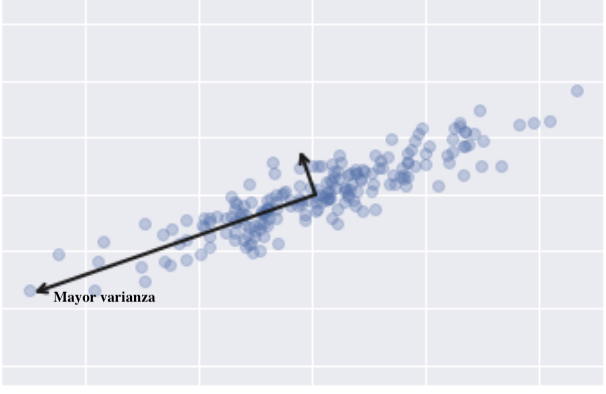

Cuando aplicamos LSA,  SVD se utiliza para encontrar las combinaciones de palabras que juntas, representan la mayor variación en los datos. Durante el proceso, los vectores TF-IDF puende ser rotados para que las nuevas dimensiones (vectores base) se alineen con las direcciones de varianza máxima. Los “vectores base” representan los ejes del nuevo espacio vectorial y son análogos a los vectores de tópicos. Cada una de las dimensiones resultantes representan una combinación de las frecuencias de palabras en lugar de la frecuencia de una palabra a la vez. En resumen,  las dimensiones resultates son combinaciones ponderadas de palabras que componen los tópicos que se utilizan a lo largo de su corpus.

Una máquina no es capaz de "entender" lo que significan las combinaciones de palabras, solo aprende que usualmente aparecer juntas. Cuando ve muchas palabras como "perro", "gato" y "iguana", las agrupa en un tema. No sabe que un nombre apropiado para ese tópico podría ser `mascotas`. Puede incluir muchas palabras como "veterinario" y "arena" en el mismo tema, o incluso palabras que significan lo opuesto entre sí. Si ocurren juntos muchos en los mismos documentos, LSA les dará puntajes altos para los temas similares. Sin embargo, la descripción o nombre del tema  depende de la interpretación humana. 

El darle un nombrea un tópico no es necesario para poder aprovecharlo en diferentes tareas. De igual forma como no no analizamos los miles de dimensiones en los vectores BoW o TF-IDF, no  se tiene que comprender el significado todos sus temas para realizar  operaciones matemáticas con esta nueva transformacion. 

LSA  nos permite  identificar las dimensiones del  vector importantes para la semántica (significado) de los documentos. Por lo que podemos descartar aquellas dimensiones (tópicos) que tengan contribuyan poco a la variación entre documentos. Si cada documento tiene aproximadamente la misma proporcion de algún tema y este no ayuda a diferenciar los documentos, entonces podemos deshacernos de él. Y eso ayudará a generalizar la representación vectorial para que funcione mejor cuando la utilicemos con documentos que no son parte del corpus de entrenamiento.

Esta generalización y compresión que realiza LSA logra lo que intentamos con el uso de las las palabras vacías o derivaciones. Pero la reducción de la dimensión LSA es mejor, porque es óptima. Retiene la mayor cantidad de información posible y no descarta ninguna palabra, solo descarta dimensiones (tópicos poco relevantes). LSA comprime el significado en menos dimensiones. Solo tenemos que retener las dimensiones de alta varianza, los temas principales de los que habla su corpus en una variedad de formas (con alta varianza). Y cada una de estas dimensiones se convierte en los tópicos del corpus, con una combinación ponderada de todas las palabras capturadas en cada tema.